<a href="https://colab.research.google.com/github/desalegn629/ViT-and-VGG16/blob/main/Deep_Learning_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import math
import os
from sklearn.model_selection import train_test_split
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout,
    GlobalAveragePooling2D  # <-- Make sure Dropout is imported here
)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.applications import ResNet50

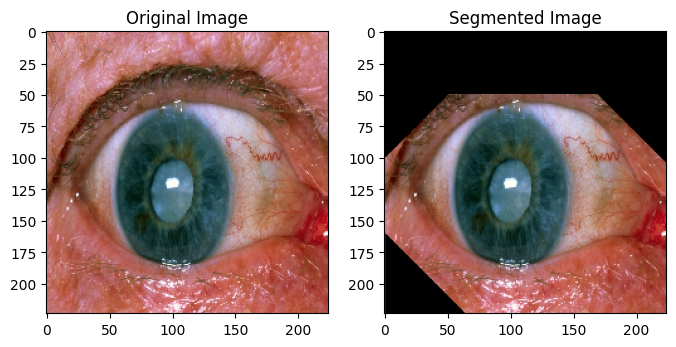

array([[[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       ...,

       [[111., 113., 192.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [ 72.,  81., 177.],
        [ 68.,  80., 176.],
        [ 65.,  74., 171.]],

       [[114., 112., 194.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [ 81.,  89., 182.],
        [ 72.,  82., 176.],
        [ 77.,  83., 178.]],

       [[116., 114., 196.],
        [  0.,   0.,   0.],
        [  0.,  

In [ ]:
# Image Resize Function
def resize_image(image, target_height=224, target_width=224):
    if image is None:
        raise ValueError("Error: Image not loaded. Please check the file path.")
    image_resized = cv2.resize(image, (target_width, target_height))
    image_resized = tf.keras.preprocessing.image.img_to_array(image_resized)
    return image_resized

# Input Shape based on data format
def get_input_shape(image_data_format, height=224, width=224, depth=3):
    if image_data_format == 'channels_first':
        input_shape = (depth, height, width)
    else:
        input_shape = (height, width, depth)
    return input_shape

# Image Segmentation Function (for oval shape)
def segment_image(image):
    # Apply the segmentation logic as per the requirement
    # Step 1: Set top portion of the image to 0
    for i in range(0, 50):
        for j in range(0, 224):
            image[i, j] = 0  # Set to black (zero) in the top portion

    # Step 2: Set the left oval portion to 0
    for j in range(0, 60):
        for i in range(100 - j, 40, -1):  # Decrease the 'i' value progressively
            image[i, j] = 0  # Set to black (zero) in the left portion

    # Step 3: Set the bottom oval portion to 0
    for i in range(223, 160, -1):
        for j in range(i - 160, 0, -1):
            image[i, j] = 0  # Set to black (zero) in the bottom portion

    # Step 4: Set the right oval portion to 0
    for i in range(223, 160, -1):
        for j in range(i - 160, 0, -1):
            image[j + 40, i] = 0  # Set to black (zero) in the right portion

    return image

# Function to load and process images
def load_and_preprocess_image(image_dir):
    # Ensure the image exists and is loaded properly
    image = cv2.imread(image_dir)  # Read the image in color (BGR format)

    # Check if the image was loaded correctly
    if image is None:
        raise FileNotFoundError(f"Error: Unable to load image at {image_dir}. Please check the file path.")

    image_resized = resize_image(image)

    # Display original image
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image_resized.astype(np.uint8), cv2.COLOR_BGR2RGB))  # Convert to RGB for correct display
    plt.title("Original Image")

    # Apply segmentation
    segmented_image = segment_image(image_resized)

    # Display segmented image
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(segmented_image.astype(np.uint8), cv2.COLOR_BGR2RGB))  # Convert to RGB for correct display
    plt.title("Segmented Image")

    plt.show()
    return segmented_image

# Path to the image
image_dir = '/content/drive/MyDrive/Data/cataract/image_101.png'  # Update this with the actual image path

# Process and display images
load_and_preprocess_image(image_dir)


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Load and preprocess segmented images (without Gabor filters)
def load_and_preprocess_images(image_dir, target_size=(224, 224)):
    images, labels = [], []
    for label, class_name in enumerate(['cataract', 'normal']):
        class_dir = os.path.join(image_dir, class_name)
        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                image_resized = cv2.resize(image, target_size)
                image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)
                images.append(image_rgb)
                labels.append(label)
    return np.array(images, dtype='float32') / 255.0, np.array(labels)

# Dataset path
image_dir = '/content/drive/MyDrive/Data'  # Update with your actual dataset directory
X, y = load_and_preprocess_images(image_dir)

# Split the dataset: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Data Augmentation for Training Data
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()  # Validation data is not augmented
train_generator = train_datagen.flow(X_train, tf.keras.utils.to_categorical(y_train), batch_size=32, shuffle=True)
val_generator = val_datagen.flow(X_val, tf.keras.utils.to_categorical(y_val), batch_size=32, shuffle=False)

# Prepare the VGG16 model for fine-tuning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tune by freezing some layers
for layer in base_model.layers[:10]:  # Freeze initial layers
    layer.trainable = False

# Add custom layers on top of VGG16
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)  # Global Average Pooling
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)  # Increased dropout to mitigate overfitting
x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(2, activation='softmax')(x)  # Final layer for binary classification

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks to improve training and avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss', patience=7, restore_best_weights=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/best_model_vgg16.h5', monitor='val_loss', save_best_only=True, verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_steps=val_generator.n // val_generator.batch_size,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)



KeyboardInterrupt: 

In [ ]:
# Evaluate the model on the test set
test_datagen = ImageDataGenerator()  # No augmentation for the test set
test_generator = test_datagen.flow(X_test, tf.keras.utils.to_categorical(y_test), batch_size=32, shuffle=False)
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_generator.n // test_generator.batch_size
)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

2/2 [==============================] - 1s 620ms/step - loss: 3.4222 - accuracy: 0.9688
Test accuracy: 96.88%


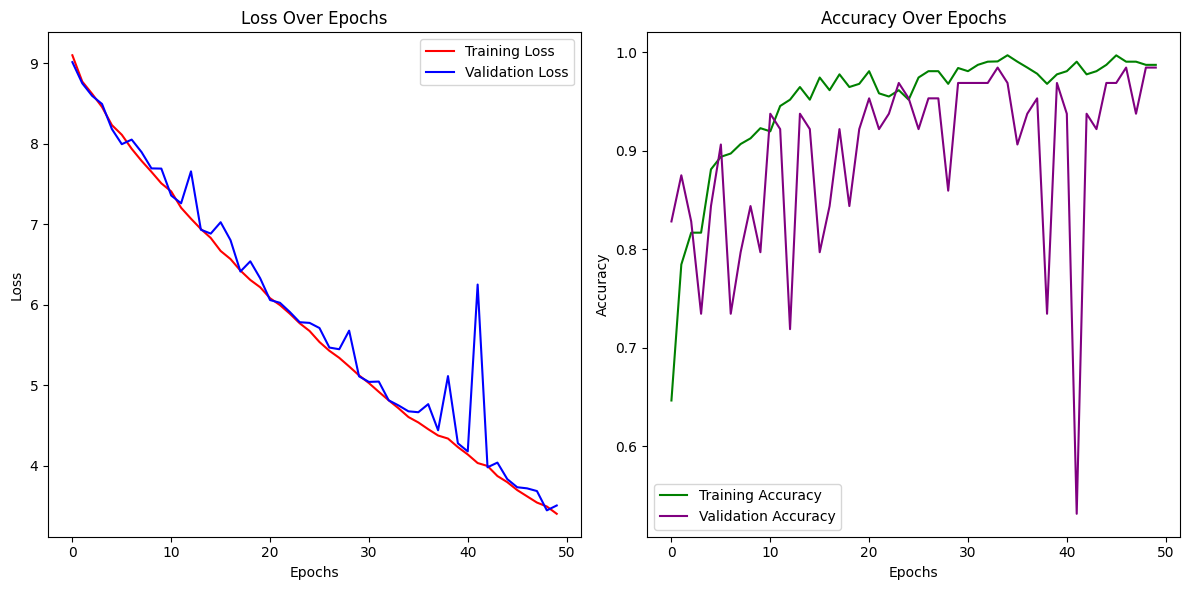

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training and validation accuracy and loss
def plot_training_history(history):
    # Extract data from the history object
    epochs = range(len(history.history['loss']))
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='blue')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy', color='green')
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='purple')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

# Call the function to display the training and validation accuracy and loss
plot_training_history(history)


3/3 [==============================] - 1s 414ms/step


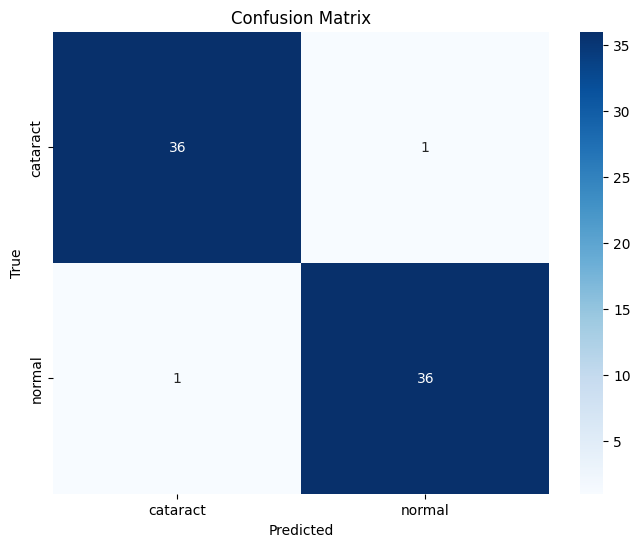

              precision    recall  f1-score   support

    cataract       0.97      0.97      0.97        37
      normal       0.97      0.97      0.97        37

    accuracy                           0.97        74
   macro avg       0.97      0.97      0.97        74
weighted avg       0.97      0.97      0.97        74



In [ ]:
# Confusion Matrix and Classification Report
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['cataract', 'normal'], yticklabels=['cataract', 'normal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report for detailed metrics
report = classification_report(y_test, y_pred, target_names=['cataract', 'normal'], output_dict=True)
print(classification_report(y_test, y_pred, target_names=['cataract', 'normal']))




In [ ]:
# Save the final model
model.save('/content/drive/MyDrive/final_vgg16_model.keras')

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/final_vgg16_model.keras')

# Function to preprocess a single image for prediction
def preprocess_image(image_path, target_size=(224, 224)):
    # Load image in grayscale, resize, and convert to RGB to match model input
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}.")
    image_resized = cv2.resize(image, target_size)
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)
    image_array = img_to_array(image_rgb) / 255.0  # Normalize the image
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    return image_array, image_rgb  # Return both processed image and original RGB image for display

# Function to predict, interpret, and display the output
def predict_single_image(image_path):
    # Preprocess the image
    image_array, image_rgb = preprocess_image(image_path)

    # Make a classification prediction
    prediction = model.predict(image_array)
    class_index = np.argmax(prediction, axis=1)[0]  # Get the predicted class index
    class_labels = ['cataract', 'normal']  # Update with your class names if different

    # Display the original image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb.astype("uint8"))
    plt.title(f"Prediction: {class_labels[class_index]}\nConfidence: {prediction[0][class_index] * 100:.2f}%")
    plt.axis('off')
    plt.show()

# Path to the single image to test
test_image_path = '/content/drive/MyDrive/Data/cataract/image_109.png'  # Update this path

# Test the single image
predict_single_image(test_image_path)


TypeError: Could not deserialize class 'Functional' because its parent module keras.src.engine.functional cannot be imported. Full object config: {'module': 'keras.src.engine.functional', 'class_name': 'Functional', 'config': {'name': 'model_6', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 224, 224, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_8'}, 'registered_name': None, 'name': 'input_8', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block1_conv1', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}, 'name': 'block1_conv1', 'inbound_nodes': [[['input_8', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block1_conv2', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 64]}, 'name': 'block1_conv2', 'inbound_nodes': [[['block1_conv1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'block1_pool', 'trainable': False, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 64]}, 'name': 'block1_pool', 'inbound_nodes': [[['block1_conv2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block2_conv1', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 64]}, 'name': 'block2_conv1', 'inbound_nodes': [[['block1_pool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block2_conv2', 'trainable': False, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 128]}, 'name': 'block2_conv2', 'inbound_nodes': [[['block2_conv1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'block2_pool', 'trainable': False, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 128]}, 'name': 'block2_pool', 'inbound_nodes': [[['block2_conv2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3_conv1', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 128]}, 'name': 'block3_conv1', 'inbound_nodes': [[['block2_pool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3_conv2', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'block3_conv2', 'inbound_nodes': [[['block3_conv1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block3_conv3', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'block3_conv3', 'inbound_nodes': [[['block3_conv2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'block3_pool', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'block3_pool', 'inbound_nodes': [[['block3_conv3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4_conv1', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}, 'name': 'block4_conv1', 'inbound_nodes': [[['block3_pool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4_conv2', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'block4_conv2', 'inbound_nodes': [[['block4_conv1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block4_conv3', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'block4_conv3', 'inbound_nodes': [[['block4_conv2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'block4_pool', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'block4_pool', 'inbound_nodes': [[['block4_conv3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5_conv1', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}, 'name': 'block5_conv1', 'inbound_nodes': [[['block4_pool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5_conv2', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}, 'name': 'block5_conv2', 'inbound_nodes': [[['block5_conv1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block5_conv3', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}, 'name': 'block5_conv3', 'inbound_nodes': [[['block5_conv2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'block5_pool', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}, 'name': 'block5_pool', 'inbound_nodes': [[['block5_conv3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'global_average_pooling2d_7', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}, 'name': 'global_average_pooling2d_7', 'inbound_nodes': [[['block5_pool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_6', 'trainable': True, 'dtype': 'float32', 'axis': [1], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 512]}, 'name': 'batch_normalization_6', 'inbound_nodes': [[['global_average_pooling2d_7', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_18', 'trainable': True, 'dtype': 'float32', 'units': 512, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': {'module': 'keras.regularizers', 'class_name': 'L2', 'config': {'l2': 0.009999999776482582}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 512]}, 'name': 'dense_18', 'inbound_nodes': [[['batch_normalization_6', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_12', 'trainable': True, 'dtype': 'float32', 'rate': 0.5, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 512]}, 'name': 'dropout_12', 'inbound_nodes': [[['dense_18', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_19', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': {'module': 'keras.regularizers', 'class_name': 'L2', 'config': {'l2': 0.009999999776482582}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 512]}, 'name': 'dense_19', 'inbound_nodes': [[['dropout_12', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_13', 'trainable': True, 'dtype': 'float32', 'rate': 0.5, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256]}, 'name': 'dropout_13', 'inbound_nodes': [[['dense_19', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_20', 'trainable': True, 'dtype': 'float32', 'units': 2, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256]}, 'name': 'dense_20', 'inbound_nodes': [[['dropout_13', 0, 0, {}]]]}], 'input_layers': [['input_8', 0, 0]], 'output_layers': [['dense_20', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': [None, 224, 224, 3]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'Adam', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': False, 'is_legacy_optimizer': False, 'learning_rate': 9.999999747378752e-05, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': 'categorical_crossentropy', 'metrics': ['accuracy'], 'loss_weights': None, 'weighted_metrics': None, 'run_eagerly': None, 'steps_per_execution': None, 'jit_compile': None}}